In [5]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import sys

import matplotlib.pyplot as plt
import numpy as np

# import wave
from scipy.io import wavfile
import sys
from scipy import signal
import argparse

import struct
import os

In [4]:

# Function to plot spectrogram
def plot_spectrogram(audio_path):
    # Load audio
    y, sr = librosa.load(audio_path, sr=None)

    # Compute Short-Time Fourier Transform (STFT)
    D = np.abs(librosa.stft(y))

    # Convert to decibels
    D_db = librosa.amplitude_to_db(D, ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()



In [3]:

def error_to_signal(y, y_pred, use_filter=1):
    """
    Error to signal ratio with pre-emphasis filter:
    https://www.mdpi.com/2076-3417/10/3/766/htm
    """
    if use_filter == 1:
        y, y_pred = pre_emphasis_filter(y), pre_emphasis_filter(y_pred)
    return np.sum(np.power(y - y_pred, 2)) / (np.sum(np.power(y, 2) + 1e-10))


def pre_emphasis_filter(x, coeff=0.95):
    return np.concatenate([x, np.subtract(x, np.multiply(x, coeff))])


def read_wave(wav_file):
    # Extract Audio and framerate from Wav File
    fs, signal = wavfile.read(wav_file)
    return signal, fs




Error to signal (with pre-emphasis filter): 0.9999999999778185
Error to signal (no pre-emphasis filter): -816733763.8537941
Creating spectrogram data...


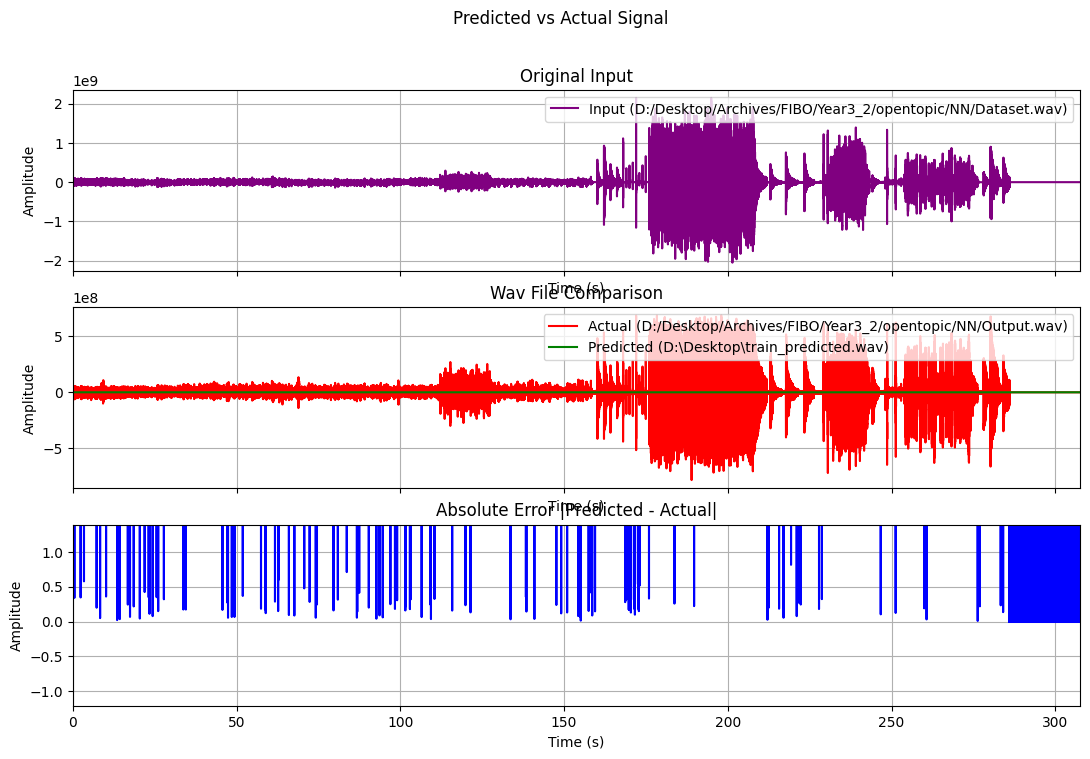

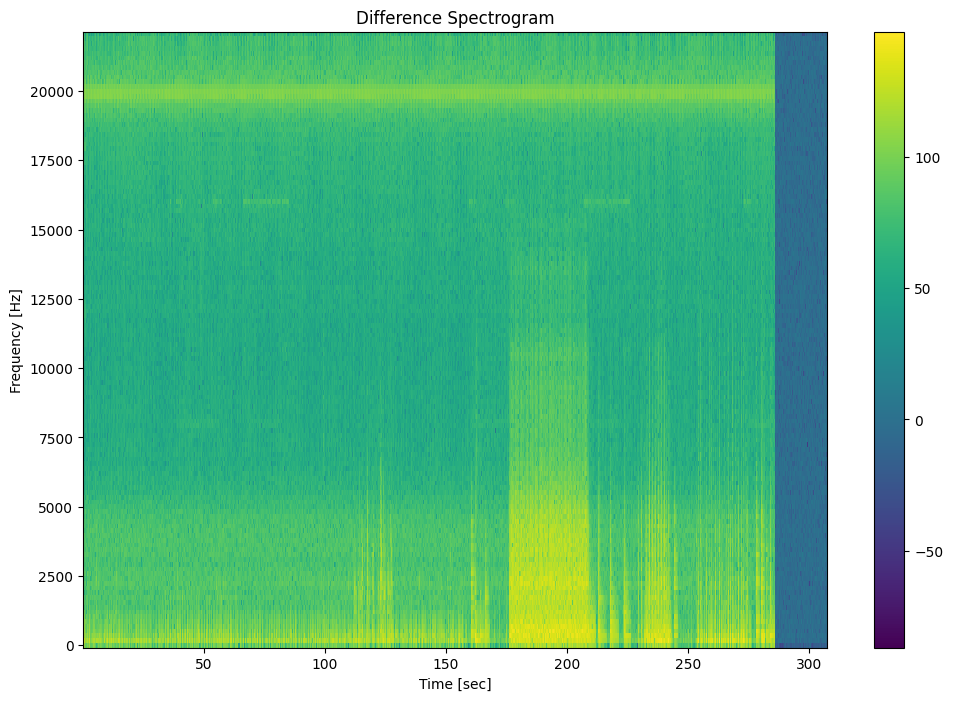

In [14]:
# Define the model directory and file paths directly.
model_dir = os.path.dirname("ongsanetnew1")
output_wav = r"D:/Desktop/Archives/FIBO/Year3_2/opentopic/NN/Output.wav"
pred_wav = r"D:\Desktop\train_predicted.wav"
input_wav = r"D:/Desktop/Archives/FIBO/Year3_2/opentopic/NN/Dataset.wav"

# Read the input (pre-effect) wav file.
signal_input, fs_input = read_wave(input_wav)

# Read the actual output wav file.
signal_actual, fs_actual = read_wave(output_wav)

# Read the predicted wav file.
signal_pred, fs_pred = read_wave(pred_wav)

# Create time vectors.
time_actual = np.linspace(0, len(signal_actual) / fs_actual, num=len(signal_actual))
time_pred = np.linspace(0, len(signal_pred) / fs_pred, num=len(signal_pred))
time_input = np.linspace(0, len(signal_input) / fs_input, num=len(signal_input))

# Set up a figure with three subplots sharing the x-axis.
fig, (ax_input, ax_actual, ax_error) = plt.subplots(3, sharex=True, figsize=(13, 8))
fig.suptitle("Predicted vs Actual Signal")

# Plot the actual signal in red and predicted signal in green on the middle subplot.
ax_actual.plot(time_actual, signal_actual, label="Actual (" + output_wav + ")", color="red")
ax_actual.plot(time_pred, signal_pred, label="Predicted (" + pred_wav + ")", color="green")
ax_actual.legend(loc="upper right")
ax_actual.set_xlabel("Time (s)")
ax_actual.set_ylabel("Amplitude")
ax_actual.set_title("Wav File Comparison")
ax_actual.grid(True)

# Determine the minimum length to trim both signals
common_length = min(len(signal_actual), len(signal_pred))
signal_actual = signal_actual[:common_length]
signal_pred = signal_pred[:common_length]

# Recompute the time vector for the trimmed signals
time_actual = np.linspace(0, common_length / fs_actual, num=common_length)
time_pred = np.linspace(0, common_length / fs_pred, num=common_length)

# Now compute the absolute error
abs_error = [abs(a - p) for a, p in zip(signal_actual, signal_pred)]

# Calculate error-to-signal ratios (with and without pre-emphasis filtering)
e2s = error_to_signal(signal_actual, signal_pred)
e2s_no_filter = error_to_signal(signal_actual, signal_pred, use_filter=0)
print("Error to signal (with pre-emphasis filter):", e2s)
print("Error to signal (no pre-emphasis filter):", e2s_no_filter)

# Plot the absolute error on the bottom subplot.
ax_error.plot(time_pred, abs_error, label="Absolute Error", color="blue")
ax_error.set_xlabel("Time (s)")
ax_error.set_ylabel("Amplitude")
ax_error.set_title("Absolute Error |Predicted - Actual|")
ax_error.grid(True)

# Plot the original input signal on the top subplot.
ax_input.plot(time_input, signal_input, label="Input (" + input_wav + ")", color="purple")
ax_input.legend(loc="upper right")
ax_input.set_xlabel("Time (s)")
ax_input.set_ylabel("Amplitude")
ax_input.set_title("Original Input")
ax_input.grid(True)

# Save the full signal comparison plot.
output_filename = os.path.join(model_dir, "signal_comparison_e2s_" + str(round(e2s, 4)) + ".png")
plt.savefig(output_filename, bbox_inches="tight")

# Create and save a zoomed-in plot (0.01 seconds) centered at the maximum of the actual signal.
signal_actual_list = signal_actual.tolist()
max_index = signal_actual_list.index(max(signal_actual_list))
zoom_start = time_input[0] - 0.005
zoom_end = time_input[0] + 0.005
plt.axis([zoom_start, zoom_end, min(signal_pred), max(signal_pred)])
zoom_output_filename = os.path.join(model_dir, "detail_signal_comparison_e2s_" + str(round(e2s, 4)) + ".png")
plt.savefig(zoom_output_filename, bbox_inches="tight")

# Reset axis to the full view.
plt.axis([0, time_input[-1], min(signal_pred), max(signal_pred)])

# Plot the spectrogram of the difference between predicted and actual signals.
plt.figure(figsize=(12, 8))
print("Creating spectrogram data...")
signal_diff = signal_pred - signal_actual
frequencies, times, Sxx = signal.spectrogram(signal_diff, fs=fs_actual)
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.colorbar()
plt.title("Difference Spectrogram")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
spectrogram_output = os.path.join(model_dir, "diff_spectrogram.png")
plt.savefig(spectrogram_output, bbox_inches="tight")

plt.show()


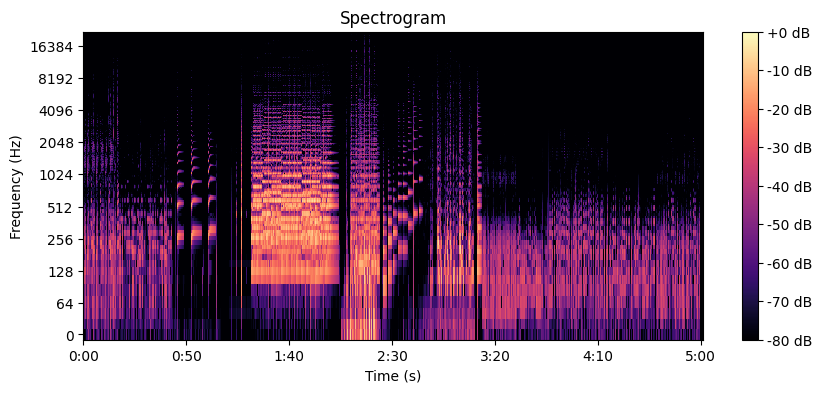

In [6]:
plot_spectrogram(r"Dataset\AD_DA_converter.wav")

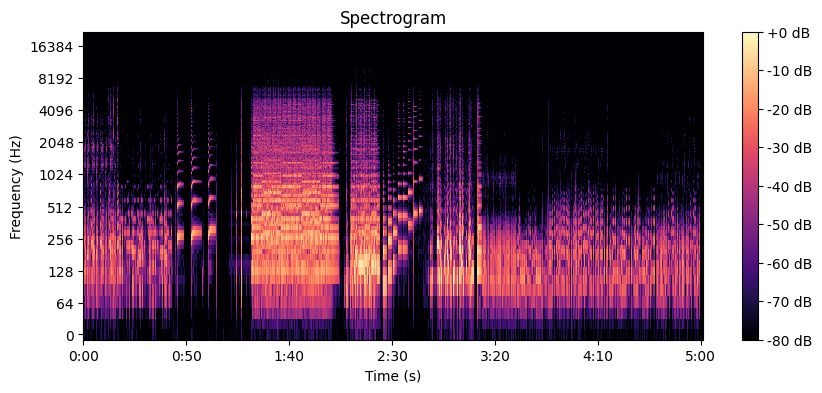

In [5]:
plot_spectrogram(r"Dataset\Orange_Rocker30 Head.wav")

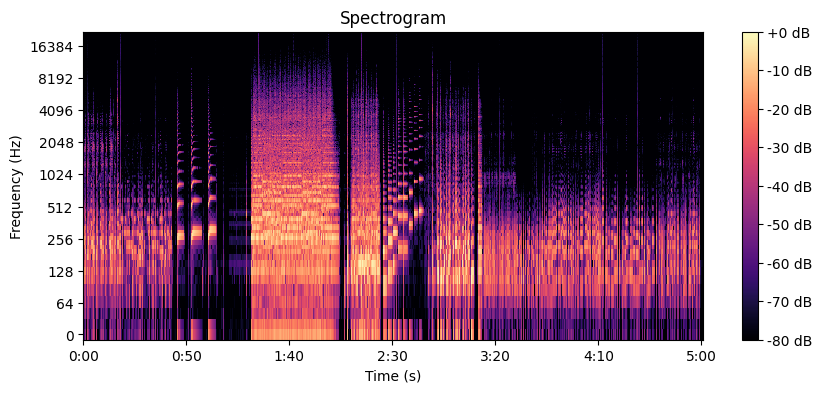

In [7]:
plot_spectrogram(r"Predicted\Orange_Rocker30_Head.wav")

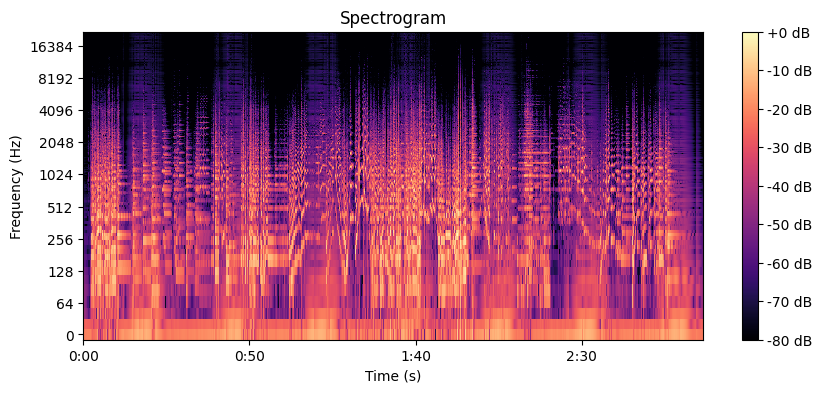

In [4]:
plot_spectrogram(r"D:\Desktop\test_5006.wav")

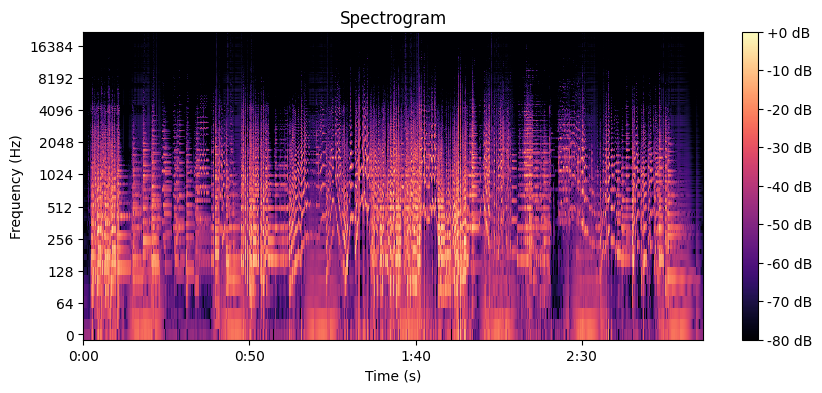

In [5]:
plot_spectrogram(r"D:\Desktop\test_800.wav")

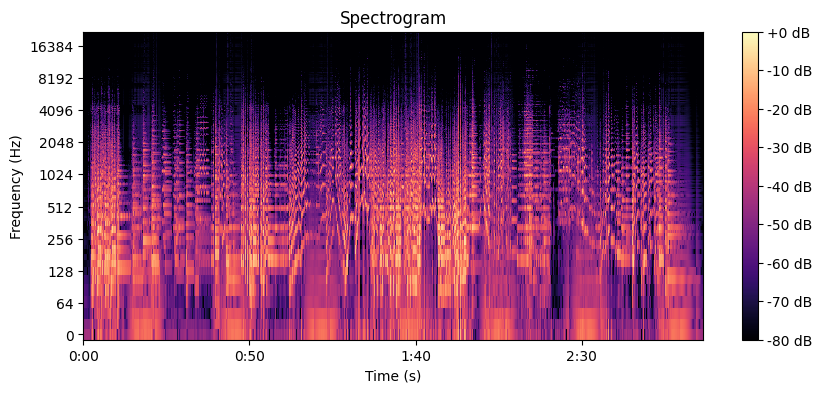

In [6]:
plot_spectrogram(r"D:\Desktop\test_600.wav")


In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def plot_diff_spectrogram(audio_path1, audio_path2):
    """
    Plot the difference of two spectrograms on a dB scale.
    
    :param audio_path1: Path to first audio file
    :param audio_path2: Path to second audio file
    """
    
    # 1. Load both audio signals
    y1, sr1 = librosa.load(audio_path1, sr=None)
    y2, sr2 = librosa.load(audio_path2, sr=None)
    
    # Optionally resample y2 if sampling rates differ
    if sr1 != sr2:
        y2 = librosa.resample(y2, orig_sr=sr2, target_sr=sr1)
        sr2 = sr1
    
    # 2. Compute STFT magnitudes
    D1 = np.abs(librosa.stft(y1))
    D2 = np.abs(librosa.stft(y2))
    
    # Make sure both spectrograms have the same time dimension
    min_frames = min(D1.shape[1], D2.shape[1])
    D1 = D1[:, :min_frames]
    D2 = D2[:, :min_frames]
    
    # 3. Convert magnitudes to dB
    #    (Using `ref=np.max` for convenience; you can also use a fixed reference)
    D_db1 = librosa.amplitude_to_db(D1, ref=np.max)
    D_db2 = librosa.amplitude_to_db(D2, ref=np.max)
    
    # 4. Compute difference in dB
    #    Positive values => audio_path1 is relatively louder at that time/freq
    #    Negative values => audio_path2 is relatively louder at that time/freq
    D_diff_db = D_db1 - D_db2
    
    # 5. Plot the difference spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D_diff_db, sr=sr1, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Difference Spectrogram (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

# Example usage:
# plot_diff_spectrogram("audio1.wav", "audio2.wav")


In [ ]:
r"Dataset\AD_DA_converter.wav"

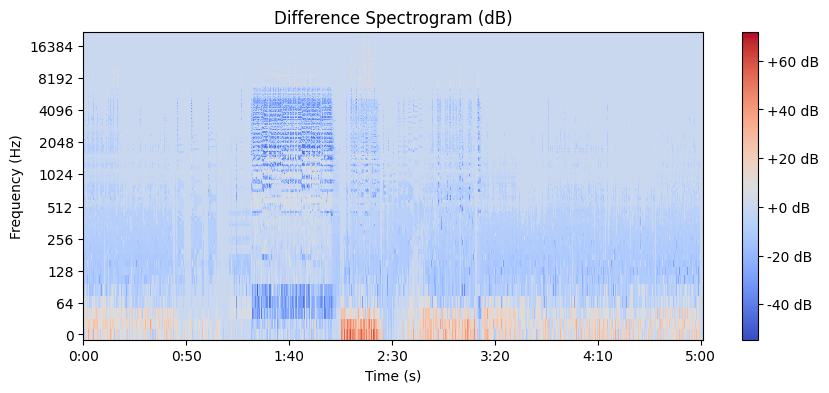

In [7]:
plot_diff_spectrogram(r"Dataset\AD_DA_converter.wav", r"Dataset\Orange_Rocker30 Head.wav")

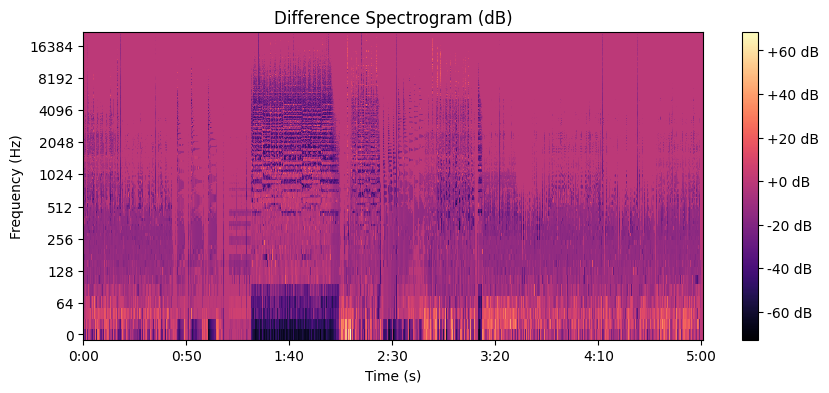

In [8]:
plot_diff_spectrogram(r"Dataset\AD_DA_converter.wav",r"Predicted\Orange_Rocker30_Head.wav")

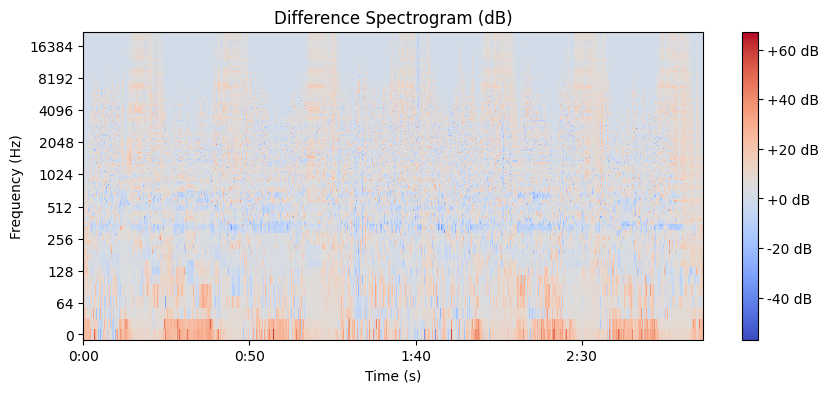

In [8]:
plot_diff_spectrogram(r"D:\Desktop\test_18961.wav",r"D:\Desktop\test_800.wav")

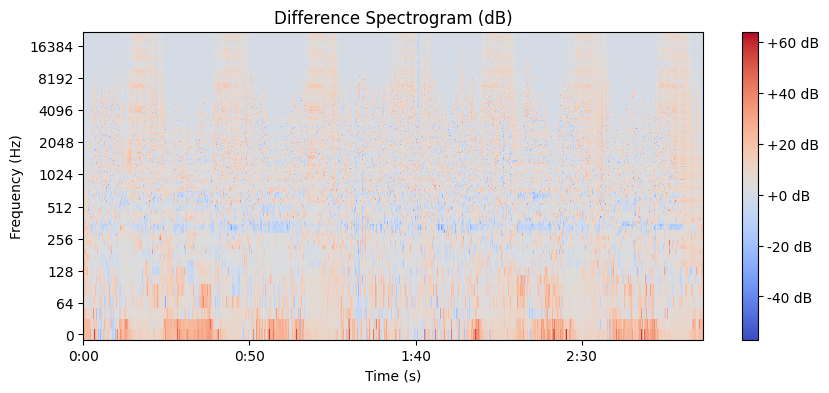

In [9]:
plot_diff_spectrogram(r"D:\Desktop\test_18961.wav",r"D:\Desktop\test_600.wav")

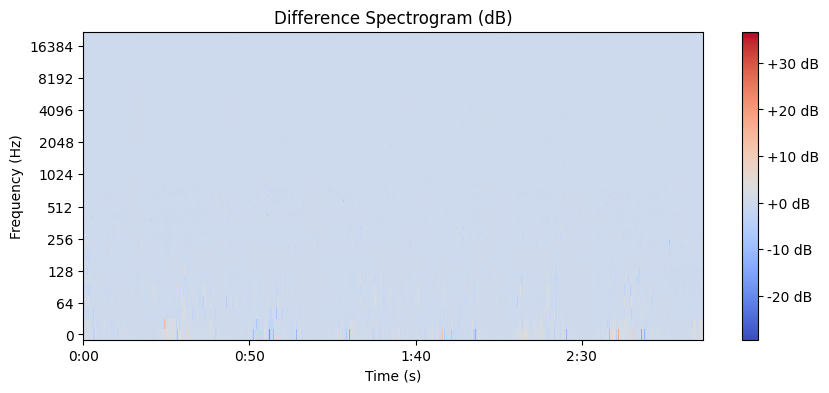

In [10]:
plot_diff_spectrogram(r"D:\Desktop\test_600.wav",r"D:\Desktop\test_800.wav")


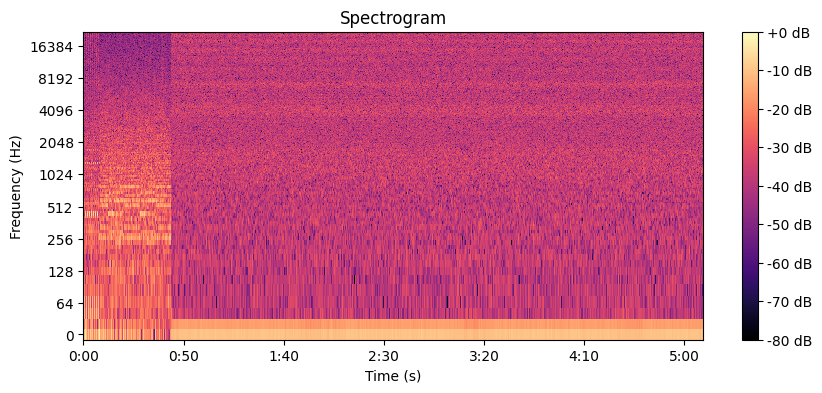

In [11]:
plot_spectrogram(r"D:\Desktop\test_600_train.wav")

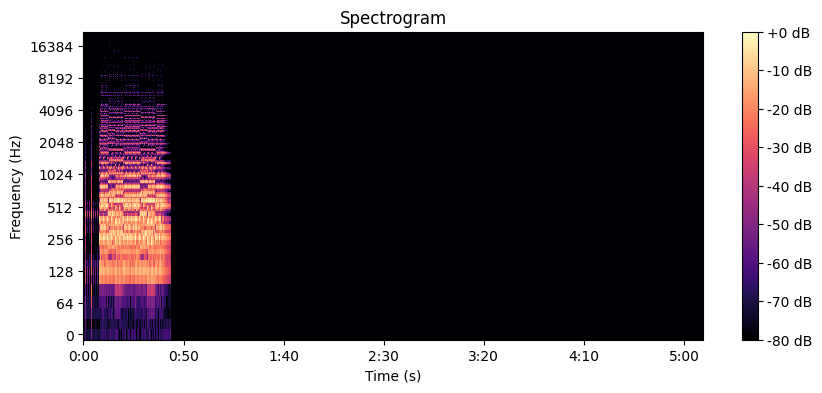

In [12]:
plot_spectrogram(r"D:/Desktop/Archives/FIBO/Year3_2/opentopic/gtrin.wav")


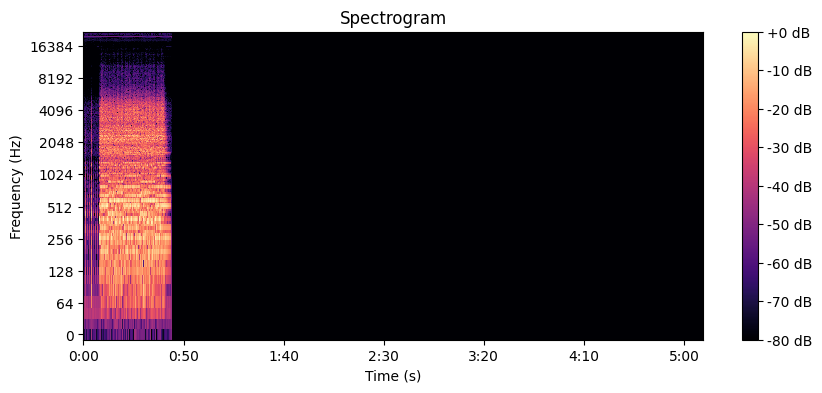

In [13]:
plot_spectrogram(r"D:/Desktop/Archives/FIBO/Year3_2/opentopic/gtrout.wav")

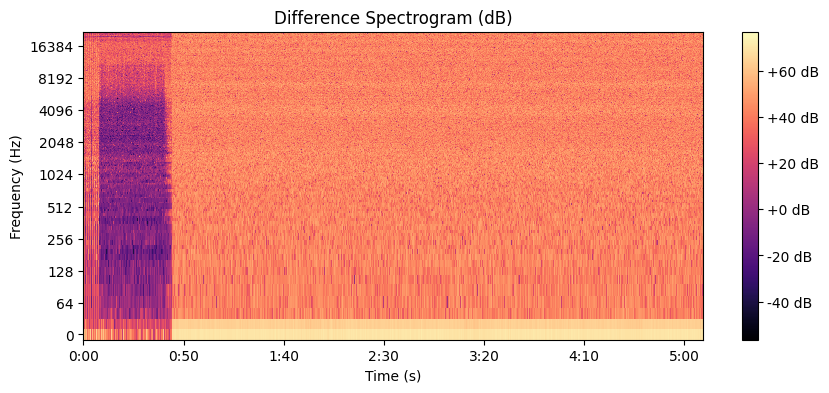

In [14]:
plot_diff_spectrogram(r"D:\Desktop\test_600_train.wav",r"D:/Desktop/Archives/FIBO/Year3_2/opentopic/gtrout.wav")


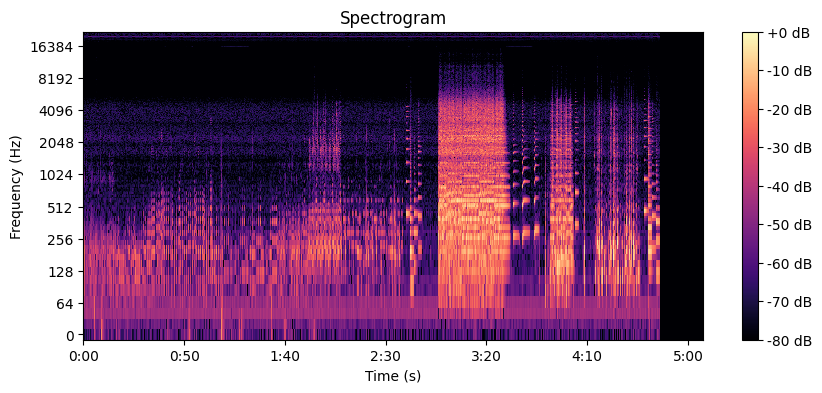

In [15]:
plot_spectrogram(r"D:/Desktop/Archives/FIBO/Year3_2/opentopic/NN/Output.wav")

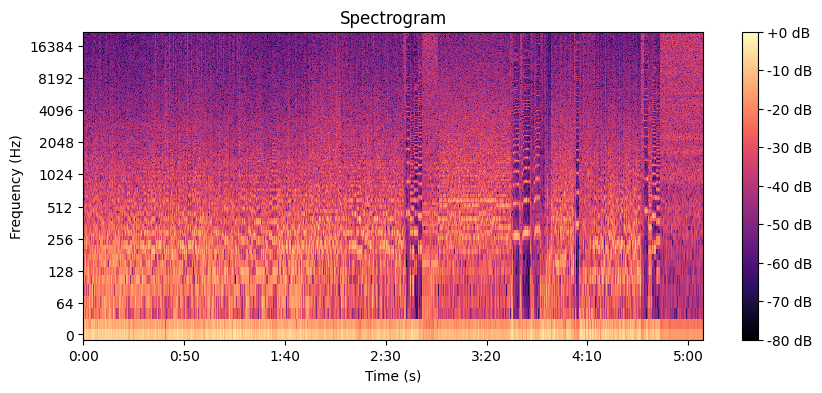

In [16]:
plot_spectrogram(r"D:\Desktop\train_predicted.wav")

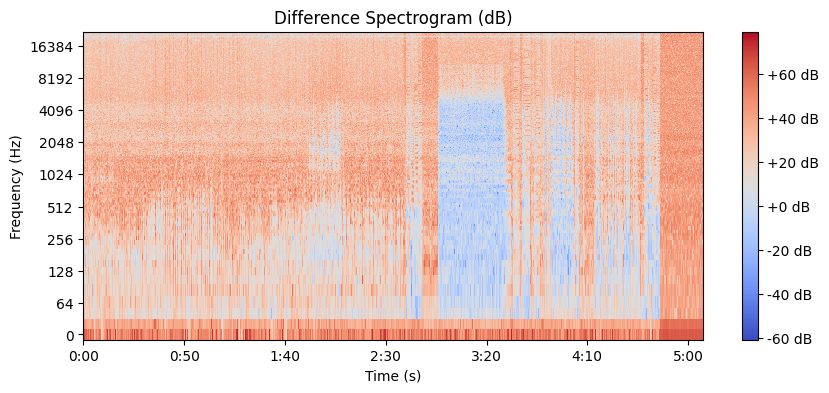

In [19]:
plot_diff_spectrogram(r"D:\Desktop\train_predicted.wav",r"D:/Desktop/Archives/FIBO/Year3_2/opentopic/NN/Output.wav")